<h1>Observations</h1>
<p>1. Obs 1</p>
<p>2. Obs 2</p>
<p>3. Obs 3</p>

In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (twitter_consumer_key, twitter_consumer_secret, twitter_access_token, twitter_access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(twitter_consumer_key, twitter_consumer_secret)
auth.set_access_token(twitter_access_token, twitter_access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Increase the size of the scatter plots
plt.rcParams["figure.figsize"] = [10,8]

In [2]:
# Target User Accounts
target_user = ("@BBC", "@CBS", "@CNN", "@FoxNews", "@NYTimes")

# Spelled out names of twitter accounts
target_names = ('BBC','CBS','CNN','Fox','NYT')

# List for dictionaries of results
results_list = []

# Variables for holding sentiments
sentiments = []

# Loop through each user
for user in target_user:

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []

    # Counter
    counter = 1

    # Variable for max_id
    oldest_tweet = None

    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(user, max_id = oldest_tweet)

        # Loop through all tweets 
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweets_ago = counter

            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

            # Add sentiments for each tweet into a list
            sentiments.append({"Username": user,
                               "Date": tweet["created_at"], 
                               "Tweet": tweet["text"],
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neg,
                               "Neutral": neu,
                               "Tweets Ago": counter})

            # Add to counter 
            counter += 1

In [3]:
# Convert sentiments to a dataframe
sentiments_pd = pd.DataFrame.from_dict(sentiments).set_index("Username")

# Export the dataframe to CSV
sentiments_pd.to_csv("Sentiment Analysis of Media Tweets.csv")

# Print out the dataframe to view results
sentiments_pd.head()

,Compound,Date,Negative,Neutral,Positive,Tweet,Tweets Ago
Username,,,,,,,
@BBC,0.0000,Sun Apr 01 20:38:27 +0000 2018,0.000,1.000,0.000,RT @BBCOne: CANNOT WAIT. \n\n@masterchefuk #M...,1
@BBC,-0.8750,Sun Apr 01 19:00:28 +0000 2018,0.333,0.667,0.000,Heiress Rachel Argyll is murdered at her famil...,2
@BBC,0.7644,Sun Apr 01 18:00:27 +0000 2018,0.000,0.752,0.248,The Generation Game is back! Mel Giedroyc and ...,3
@BBC,0.6114,Sun Apr 01 17:42:22 +0000 2018,0.000,0.637,0.363,RT @BBCSport: Happy April Fool's Day everyone!...,4
@BBC,0.6369,Sun Apr 01 17:00:26 +0000 2018,0.000,0.704,0.296,🤖 Who'd love their next takeaway to be deliver...,5


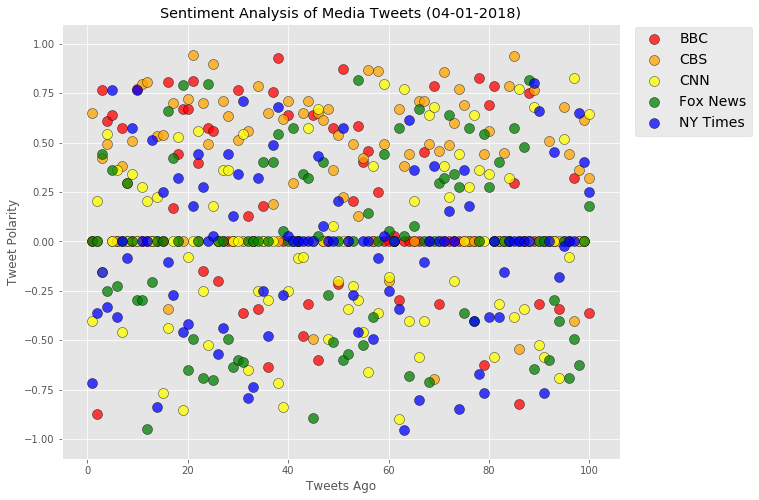

In [4]:
# This section creates the scatterplot of sentiments of the last 100 tweets sent out by each news organization

# Clear plot, just in case
plt.clf()

# Set list of colors
colors = ['red', 'orange', 'yellow', 'green', 'blue']

# Loop through each twitter account
for index, user in enumerate(target_user):
    
    # Create scatterplot for each twitter account
    plt.scatter(sentiments_pd[sentiments_pd.index==user]["Tweets Ago"], 
                sentiments_pd[sentiments_pd.index==user]["Compound"],
                marker="o", facecolors=colors[index], edgecolors="black", s=100, alpha=0.75)

# Adjust other graph properties
now = datetime.now()
now = now.strftime("%m-%d-%Y")
plt.title(f"Sentiment Analysis of Media Tweets ({now})")
plt.legend(target_names, loc='best', bbox_to_anchor=(1.25, 1.01), prop={'size': 14})
plt.ylim(-1.1, 1.1)
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.show()

# Save the chart
plt.savefig("Sentiment Analysis of Media Tweets.png")

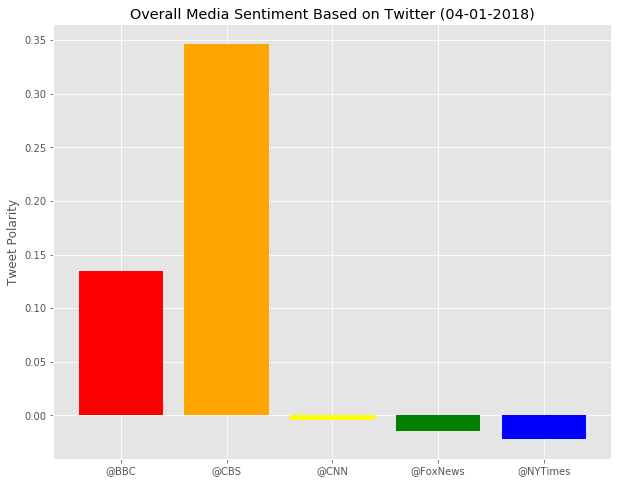

In [5]:
# This section creates the bar graph showing the overall sentiments of the last 100 tweets from each organization

# Clear plot, just in case
plt.clf()

# List for holding overall sentiment
overall_sentiment_list = []

# Create values for x-axis
x_axis = np.arange(len(target_user))

# Loop through each twitter account
for user in target_user:
    
    # Append average compound score to list
    overall_sentiment_list.append(sentiments_pd[sentiments_pd.index==user]["Compound"].mean())
    
plt.bar(x_axis, overall_sentiment_list, color=colors, align="edge")
    
# Adjust other graph properties
now = datetime.now()
now = now.strftime("%m-%d-%Y")
plt.title(f"Overall Media Sentiment Based on Twitter ({now})")
#plt.ylim(-1.1, 1.1)
tick_locations = [value+0.4 for value in x_axis]
plt.xticks(tick_locations, target_names)
plt.ylabel("Tweet Polarity")
plt.show()

# Save the chart
plt.savefig("Overall Media Sentiment.png")